In [205]:
import sys
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import os
import re

from keras.layers import Input, Dense, LSTM, Embedding, Lambda, Dot, Concatenate
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adadelta
from keras.callbacks import Callback
from keras.utils import to_categorical
from keras import backend as K

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from harness import TrainingHarness

pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Data Preprocessing

In [77]:
with open('../data/converted/amazon-google/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-google')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

In [78]:
# drop columns that do not contain embeddings
# data['train_1'] = data['train_1'].drop(['id1', 'price'], axis = 'columns')
# data['train_2'] = data['train_2'].drop(['id2', 'price'], axis = 'columns')
# data['val_1'] = data['val_1'].drop(['id1', 'price'], axis = 'columns')
# data['val_2'] = data['val_2'].drop(['id2', 'price'], axis = 'columns')
# data['test_1'] = data['test_1'].drop(['id1', 'price'], axis = 'columns')
# data['test_2'] = data['test_2'].drop(['id2', 'price'], axis = 'columns')

# concatenate all embedding columns so each record becomes one giant list
# def concat_columns(x):
#     y = tuple(x['manufacturer']) + tuple(x['title'])
#     return y

# for df_name in datasets:
#     data[df_name] = data[df_name].apply(concat_columns, axis='columns')
    
# # pad all sequences with less than 500 indices with zeros
# # limit all sequences to 500 indices
# maxlen = 50
# for df_name in datasets:
#     data[df_name] = pad_sequences(data[df_name], maxlen=maxlen, padding='post', truncating='post')

In [284]:
nan_idx = map['word2idx']['NaN']

train_1_title = data['train_1']['name']
train_1_description = data['train_1']['description']
train_1_manufacturer = data['train_1']['manufacturer']
train_1_title_isna = data['train_1']['name'].apply(lambda x: x == [nan_idx])
train_1_description_isna = data['train_1']['description'].apply(lambda x: x == [nan_idx])
train_1_manufacturer_isna = data['train_1']['manufacturer'].apply(lambda x: x == [nan_idx])

train_1_price = data['train_1']['price'].values.reshape(-1, 1)
train_1_price_isna = train_1_price == 0

train_2_title = data['train_2']['name']
train_2_description = data['train_2']['description']
train_2_manufacturer = data['train_2']['manufacturer']
train_2_title_isna = data['train_2']['name'].apply(lambda x: x == [nan_idx])
train_2_description_isna = data['train_2']['description'].apply(lambda x: x == [nan_idx])
train_2_manufacturer_isna = data['train_2']['manufacturer'].apply(lambda x: x == [nan_idx])

def str_to_num(x):
    return float(re.sub('[^0-9|^\.]', '', x))
train_2_price = data['train_2']['price'].apply(str_to_num).values.reshape(-1, 1)
train_2_price_isna = train_2_price == 0

train_title_isna = (train_1_title_isna | train_2_title_isna)
train_description_isna = train_1_description_isna | train_2_description_isna
train_manufacturer_isna = train_1_manufacturer_isna | train_2_manufacturer_isna
train_price_isna = train_1_price_isna | train_2_price_isna

train_title_isna = train_title_isna.values.reshape(-1, 1).astype(np.float32)
train_description_isna = train_description_isna.values.reshape(-1, 1).astype(np.float32)
train_manufacturer_isna = train_manufacturer_isna.values.reshape(-1, 1).astype(np.float32)
train_price_isna = train_price_isna.reshape(-1, 1).astype(np.float32)

train_1_title_maxlen = train_1_title.apply(lambda x: len(x)).max()
train_1_description_maxlen = train_1_description.apply(lambda x: len(x)).max()
train_1_manufacturer_maxlen = train_1_manufacturer.apply(lambda x: len(x)).max()

train_2_title_maxlen = train_2_title.apply(lambda x: len(x)).max()
train_2_description_maxlen = train_2_description.apply(lambda x: len(x)).max()
train_2_manufacturer_maxlen = train_2_manufacturer.apply(lambda x: len(x)).max()

val_1_title = data['val_1']['name']
val_1_description = data['val_1']['description']
val_1_manufacturer = data['val_1']['manufacturer']
val_1_title_isna = data['val_1']['name'].apply(lambda x: x == [nan_idx])
val_1_description_isna = data['val_1']['description'].apply(lambda x: x == [nan_idx])
val_1_manufacturer_isna = data['val_1']['manufacturer'].apply(lambda x: x == [nan_idx])

val_1_price = data['val_1']['price'].values.reshape(-1, 1)
val_1_price_isna = val_1_price == 0

val_2_title = data['val_2']['name']
val_2_description = data['val_2']['description']
val_2_manufacturer = data['val_2']['manufacturer']
val_2_title_isna = data['val_2']['name'].apply(lambda x: x == [nan_idx])
val_2_description_isna = data['val_2']['description'].apply(lambda x: x == [nan_idx])
val_2_manufacturer_isna = data['val_2']['manufacturer'].apply(lambda x: x == [nan_idx])

val_2_price = data['val_2']['price'].apply(str_to_num).values.reshape(-1, 1)
val_2_price_isna = val_2_price == 0

val_title_isna = val_1_title_isna | val_2_title_isna
val_description_isna = val_1_description_isna | val_2_description_isna
val_manufacturer_isna = val_1_manufacturer_isna | val_2_manufacturer_isna
val_price_isna = val_1_price_isna | val_2_price_isna

val_title_isna = val_title_isna.values.reshape(-1, 1).astype(int)
val_description_isna = val_description_isna.values.reshape(-1, 1).astype(int)
val_manufacturer_isna = val_manufacturer_isna.values.reshape(-1, 1).astype(int)

maxlen_title = min(max(train_1_title_maxlen, train_2_title_maxlen), 50)
maxlen_description = min(max(train_1_description_maxlen, train_2_description_maxlen), 50)
maxlen_manufacturer = min(max(train_1_manufacturer_maxlen, train_2_manufacturer_maxlen), 50)
maxlen = max(maxlen_title, maxlen_description, maxlen_manufacturer)

print(maxlen_title, maxlen_description, maxlen_manufacturer)

train_1_title = pad_sequences(train_1_title, maxlen=maxlen_title,
                              padding='post', truncating='post')
train_2_title = pad_sequences(train_2_title, maxlen=maxlen_title,
                              padding='post', truncating='post')
train_1_description = pad_sequences(train_1_description, maxlen=maxlen_description,
                              padding='post', truncating='post')
train_2_description = pad_sequences(train_2_description, maxlen=maxlen_description,
                              padding='post', truncating='post')
train_1_manufacturer = pad_sequences(train_1_manufacturer, maxlen=maxlen_manufacturer,
                              padding='post', truncating='post')
train_2_manufacturer = pad_sequences(train_2_manufacturer, maxlen=maxlen_manufacturer,
                              padding='post', truncating='post')

val_1_title = pad_sequences(val_1_title, maxlen=maxlen_title,
                              padding='post', truncating='post')
val_2_title = pad_sequences(val_2_title, maxlen=maxlen_title,
                              padding='post', truncating='post')
val_1_description = pad_sequences(val_1_description, maxlen=maxlen_description,
                              padding='post', truncating='post')
val_2_description = pad_sequences(val_2_description, maxlen=maxlen_description,
                              padding='post', truncating='post')
val_1_manufacturer = pad_sequences(val_1_manufacturer, maxlen=maxlen_manufacturer,
                              padding='post', truncating='post')
val_2_manufacturer = pad_sequences(val_2_manufacturer, maxlen=maxlen_manufacturer,
                              padding='post', truncating='post')

train_y = to_categorical(data['train_y'])
val_y = to_categorical(data['val_y'])

41 50 7


# Build Model

In [80]:
glove_matrix = np.load(os.path.join(data_dir, 
                                    'converted',
                                    'amazon-google',
                                    'glove-300.matrix.npy'))

In [291]:
n_hidden = 50

input_left_title = Input(shape=(maxlen_title,))
input_right_title = Input(shape=(maxlen_title,))
input_left_description = Input(shape=(maxlen_description,))
input_right_description = Input(shape=(maxlen_description,))
input_left_manufacturer = Input(shape=(maxlen_manufacturer,))
input_right_manufacturer = Input(shape=(maxlen_manufacturer,))
input_left_price = Input(shape=(1,))
input_right_price = Input(shape=(1,))

input_title_isna = Input(shape=(1,))
input_description_isna = Input(shape=(1,))
input_manufacturer_isna = Input(shape=(1,))
input_price_isna = Input(shape=(1,))

embedding_layer = Embedding(glove_matrix.shape[0],
                            glove_matrix.shape[1],
                            weights=[glove_matrix],
                            input_length=maxlen,
                            trainable=False,
                            mask_zero=True)

embedded_left_title = embedding_layer(input_left_title)
embedded_right_title = embedding_layer(input_right_title)
embedded_left_description = embedding_layer(input_left_description)
embedded_right_description = embedding_layer(input_right_description)
embedded_left_manufacturer = embedding_layer(input_left_manufacturer)
embedded_right_manufacturer = embedding_layer(input_right_manufacturer)

averaging_layer = Lambda(lambda x: K.mean(x, axis=1))
averaged_left_title = averaging_layer(embedded_left_title)
averaged_right_title = averaging_layer(embedded_right_title)
averaged_left_description = averaging_layer(embedded_left_description)
averaged_right_description = averaging_layer(embedded_right_description)
averaged_left_manufacturer = averaging_layer(embedded_left_manufacturer)
averaged_right_manufacturer = averaging_layer(embedded_right_manufacturer)

cosine_similarity_layer = Dot(axes=1, normalize=True)
similarized_title = cosine_similarity_layer([averaged_left_title, averaged_right_title])
similarized_description = cosine_similarity_layer([averaged_left_description, averaged_right_description])
similarized_manufacturer = cosine_similarity_layer([averaged_left_manufacturer, averaged_right_manufacturer])

subtracting_layer = Lambda(lambda x: K.abs(x[0] - x[1]))
differenced_price = subtracting_layer([input_left_price, input_right_price])

concatenate_layer = Concatenate(axis=-1)
concatenated_similarities = concatenate_layer([similarized_title,
                                               similarized_description,
                                               similarized_manufacturer,
                                               differenced_price,
                                               input_title_isna,
                                               input_description_isna,
                                               input_manufacturer_isna,
                                               input_price_isna])

dense_hidden_output_1 = Dense(units=50, activation='relu')(concatenated_similarities)
dense_hidden_output_2 = Dense(units=25, activation='relu')(dense_hidden_output_1)
dense_hidden_output_3 = Dense(units=10, activation='relu')(dense_hidden_output_1)
dense_final_output = Dense(units=2, activation='softmax')(dense_hidden_output_3)

# lstm_layer = LSTM(n_hidden, go_backwards=True)

# output_left = lstm_layer(embedded_right)
# output_right = lstm_layer(embedded_left)

# def distance_metric(x1, x2):
#     l1 = -K.sum(K.abs(x1 - x2), axis=1, keepdims=True)
#     return K.exp(l1)

# merge_layer = Merge(mode=lambda x: K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True)),
#                     output_shape=lambda x: (x[0][0], 1))

# distance = merge_layer([output_left, output_right])

malstm = Model([input_left_title, input_right_title,
                input_left_description, input_right_description,
                input_left_manufacturer, input_right_manufacturer,
                input_left_price, input_right_price,
                input_title_isna,
                input_description_isna,
                input_manufacturer_isna,
                input_price_isna
               ],
               [dense_final_output])

In [292]:
compile_args = dict(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['acc'])

malstm.compile(**compile_args)

In [293]:
loss = list()
val_loss = list()
acc = list()
val_acc = list()

In [295]:
fit_args = dict(x = [train_1_title, train_2_title,
                     train_1_description, train_2_description,
                     train_1_manufacturer, train_2_manufacturer,
                     train_1_price, train_2_price,
                     train_title_isna,
                     train_description_isna,
                     train_manufacturer_isna,
                     train_price_isna],
                y = train_y,
#                 validation_data = ([val_1_title, val_2_title,
#                                     val_1_description, val_2_description,
#                                     val_1_manufacturer, val_2_manufacturer], val_y),
                epochs = 10,
                batch_size = 1024,
                validation_split = 0.2,
                shuffle = False)

history = malstm.fit(**fit_args)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])
acc.extend(history.history['acc'])
val_acc.extend(history.history['val_acc'])

Train on 84032 samples, validate on 21008 samples
Epoch 1/10
84032/84032 [==============================] - 12s 138us/step - loss: 0.0655 - acc: 0.9900 - val_loss: 0.0850 - val_acc: 0.9912
Epoch 2/10
84032/84032 [==============================] - 11s 135us/step - loss: 0.0699 - acc: 0.9915 - val_loss: 0.0737 - val_acc: 0.9910
Epoch 3/10
84032/84032 [==============================] - 11s 135us/step - loss: 0.0641 - acc: 0.9917 - val_loss: 0.0700 - val_acc: 0.9914
Epoch 4/10
84032/84032 [==============================] - 12s 142us/step - loss: 0.0608 - acc: 0.9922 - val_loss: 0.0664 - val_acc: 0.9919
Epoch 5/10
84032/84032 [==============================] - 11s 133us/step - loss: 0.0574 - acc: 0.9926 - val_loss: 0.0618 - val_acc: 0.9929
Epoch 6/10
84032/84032 [==============================] - 12s 139us/step - loss: 0.0528 - acc: 0.9928 - val_loss: 0.0558 - val_acc: 0.9931
Epoch 7/10
84032/84032 [==============================] - 12s 139us/step - loss: 0.0482 - acc: 0.9928 - val_loss: 0.

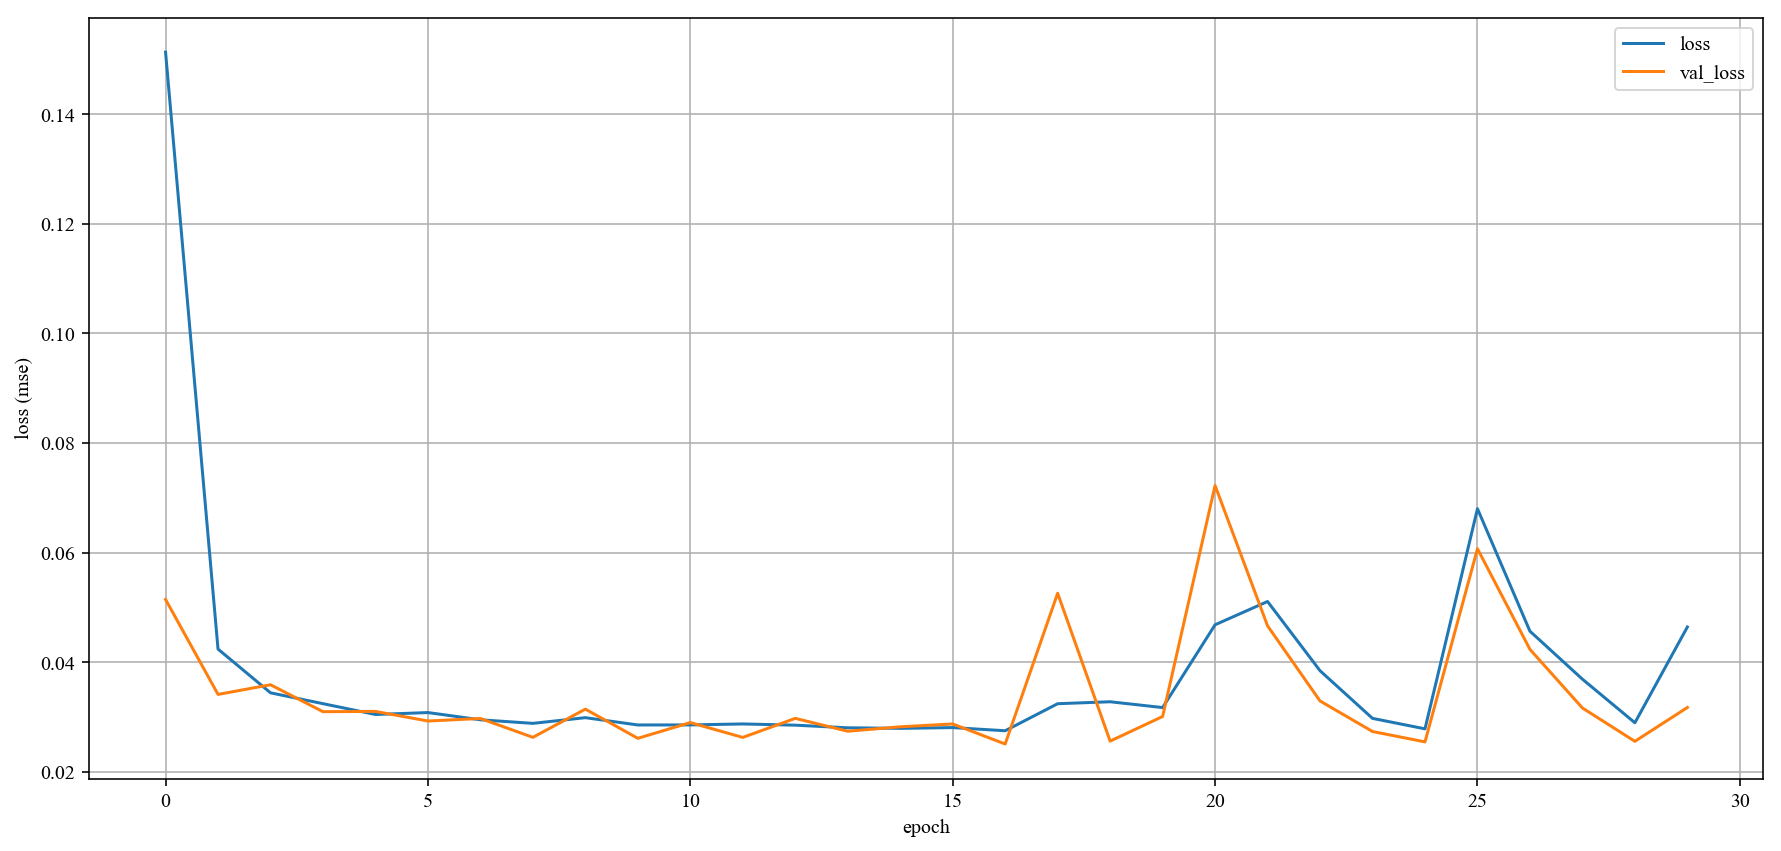

In [239]:
plt.figure(figsize = (15,7))
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
#plt.ylim(0.003, 0.012)
plt.grid(True)

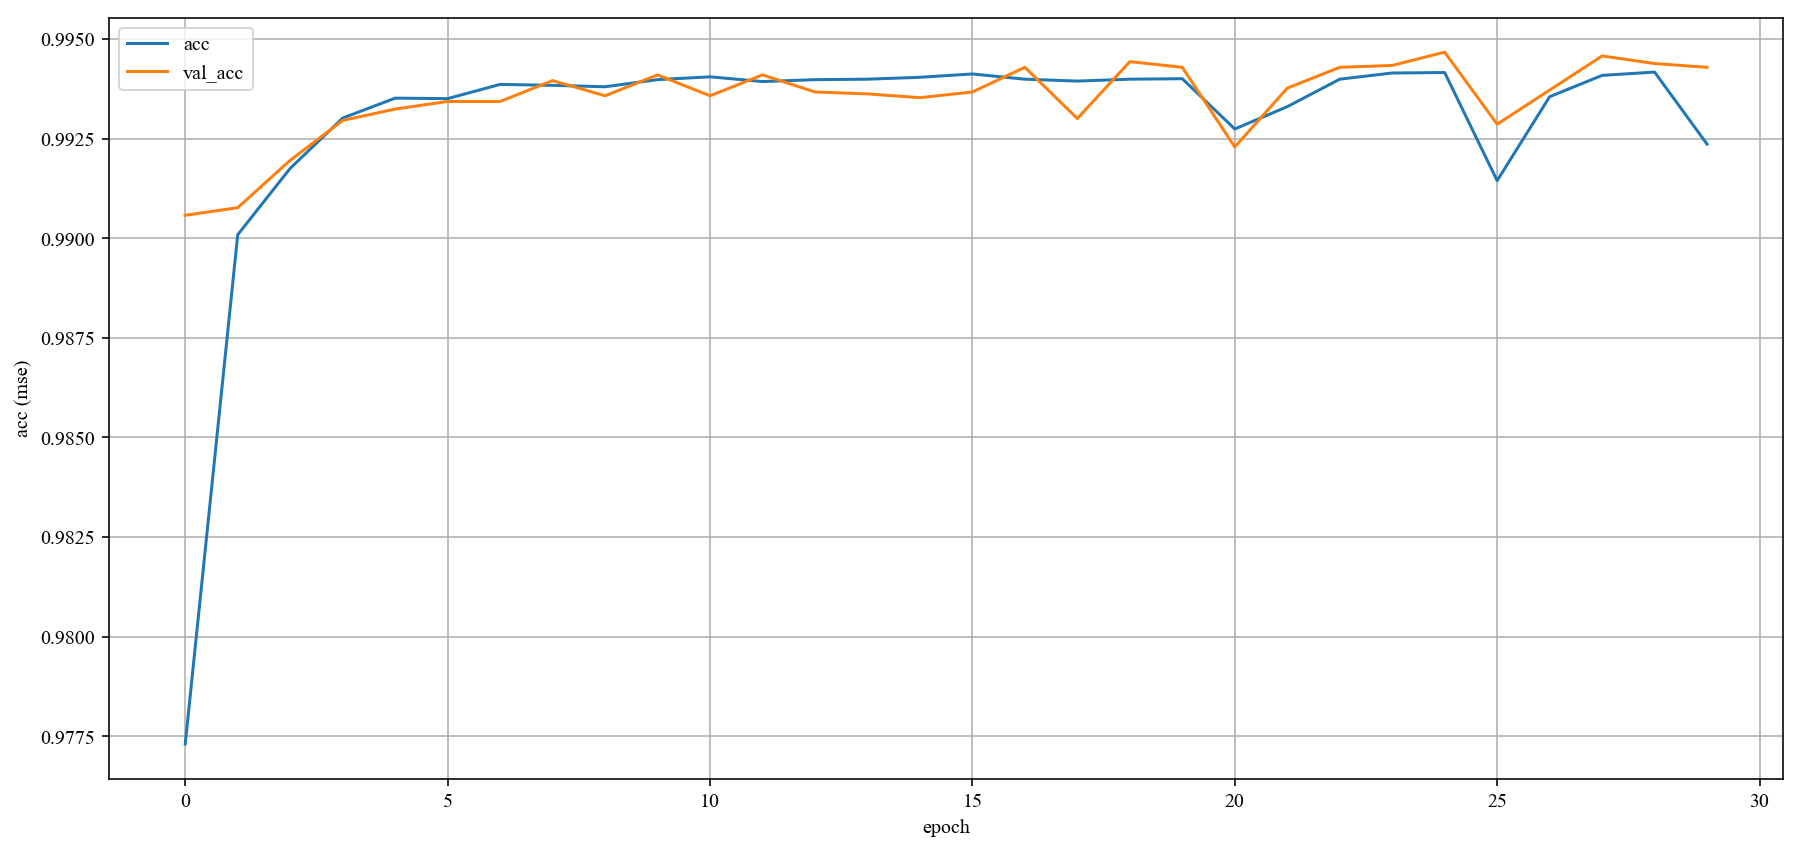

In [240]:
plt.figure(figsize = (15,7))
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc (mse)')
#plt.ylim(0.988, 1)
plt.grid(True)

In [303]:
from gensim.models import KeyedVectors
model = KeyedVectors.load('../data/embeddings/glove-300.gensim')

In [312]:
model.most_similar('solitaire')

[('solitare', 0.738432765007019),
 ('Solitaire', 0.7114996910095215),
 ('mahjong', 0.628769040107727),
 ('klondike', 0.6004503965377808),
 ('diamond', 0.5911897420883179),
 ('freecell', 0.5812501907348633),
 ('solitaires', 0.576423168182373),
 ('carat', 0.5596097111701965),
 ('marquise', 0.5592507123947144),
 ('diamonds', 0.5482845902442932)]

In [296]:
data['train_1']

,id1,name,description,manufacturer,price
0,b000lu89uc,"[1133, 1044, 1640, 1641]","[13163, 10884, 76, 81, 13164, 6617, 13165, 2388, 3093, 76, 7183, 1641, 4171, 1104, 20, 3354, 4166, 220, 13166, 152, 248]",[1197],9.99
1,b000cp4ja0,"[924, 874, 248, 56, 29, 1197]","[2888, 3366, 69, 2586, 2244, 176, 13981, 2918, 76, 5191, 941, 3800, 2474, 13982, 1102, 43, 3035, 76, 1806, 1700, 2538, 2244, 13983, 924, 3821, 33, 5741, 69, 13984, 180, 2477, 76, 2294, 13488, 2395, 1010, 5040, 13985, 51, 2244, 240, 65, 1429, 13986, 1177, 2259, 76, 2294, 147, 5040, 2276, 498, 406, 76, 13987, 69, 2888, 4496, 924, 13988, 2221, 5658, 65, 1429, 176, 13989, 5981, 7421, 2517, 2307, 13990, 317, 76, 2888, 8519, 13991, 924, 76, 147, 51, 11921, 63, 558, 1071, 316, 148, 43, 2700, 416, 3135, 51, 5870, 1429, 924, 76, 4934]","[1197, 129]",39.99
2,b0002cu240,"[885, 886, 887, 211, 7, 33, 138]","[211, 7, 8, 98, 5947, 7088, 3135, 3001, 123, 2882, 1113, 10, 290, 1451, 123, 2515, 63, 2043, 20, 2401, 4, 123, 2043, 20, 2401, 826, 4078, 43, 2370, 1102, 1232, 33, 673, 2208, 2567, 2131, 2736, 76, 4667, 123, 863, 2592, 220, 123, 129, 3300]","[238, 1296]",149.95
3,b000hlt5j4,"[770, 771, 772]","[770, 1406, 1691, 673, 3228, 177]",[200],29.95
4,b000v05f4k,"[1589, 129, 931, 69, 536, 427, 4, 44]","[874, 1102, 2395, 1010, 3496, 2209, 403, 123, 2305, 259, 1429, 240, 826, 4392, 1143, 3444, 43, 123, 8992, 148, 220, 123, 1192, 1589, 931, 571, 536, 9808, 1589, 931, 427, 826, 827, 10634, 148, 33, 1429, 3089, 64, 3366, 1104, 76, 1104, 2307, 2888, 3399, 76, 4622, 403, 3430, 220, 3373, 1017, 76, 1305, 12867, 2596, 12868, 2404, 43, 11456, 827, 3357, 2542, 1102, 2395, 7931, 3166, 3113, 76, 3556, 498, 406, 1913, 1429, 3346, 8141, 1919, 1534, 7397, 123, 610, 2074, 10817, 43, 12869, 498, 1589, 931, 427, 1102, 2395, 2208, 2977, 1919, 3166, 2259, 2266, 3619, 3820, ...]","[1589, 129]",0.00
5,b00013wh0w,"[1693, 461, 1694, 1695, 462, 76, 1696]","[123, 461, 1694, 1695, 462, 76, 1696, 3400, 827, 518, 462, 76, 827, 518, 1696, 7469, 1102, 123, 151, 220, 4536, 65, 1036, 4229, 3975, 3143, 1104, 20, 2317, 76, 2300, 2350, 827, 3508, 80, 462, 248, 165, 2406, 1719, 7392, 33, 827, 261, 367, 818, 1875, 1993]","[1693, 2189]",0.00
6,b0009yegcu,"[175, 817, 177, 149]","[175, 817, 177, 149, 8, 137, 1244, 1246, 1216, 520, 236, 10]","[200, 177]",29.99
7,b000eqieik,"[1781, 1782, 1781, 1782, 184, 56, 88]","[1781, 1782, 184, 56, 2494, 8779, 6, 13759, 33, 9748, 76, 410, 843, 2497, 14468, 2216, 43, 545, 2815, 11829, 13759, 220, 6454, 76, 5436, 3205, 1102, 2395, 3155, 1754, 43, 3970, 7937, 2074, 6, 14469, 1534, 514, 2244, 7607, 1919, 2418, 6454, 1919, 5436, 6, 65, 397, 76, 3155, 1104, 2372, 1781, 1782, 14470, 2865, 2641, 2676, 13759, 51, 5064, 1919, 3554, 1466, 76, 410, 3934, 2429, 3075, 847, 2372, 397, 14471, 912, 498, 45, 397, 1553, 138, 298, 299, 2026, 76, 44, 236]","[1729, 129]",299.95
8,b000gaoxgg,"[50, 707, 708, 129, 87, 498, 161, 88]","[827, 3093, 4059, 43, 611, 1593, 76, 611, 1593, 1575, 2566, 2866, 3563, 220, 5468, 4, 3930, 498, 4251, 5143, 5810, 205, 3461, 2217, 43, 4995, 123, 2793, 3017, 220, 707, 708, 2870, 4636, 611, 1593, 2358, 76, 1575, 76, 3281, 1833, 5811, 2538, 906, 5812]",[16514],0.00
9,b000m5ailo,"[1271, 2039, 57, 149, 408, 161]","[4, 2128, 2305, 63, 123, 15459, 2266, 604, 889, 5144, 2884, 1040, 843, 76, 457, 57, 736, 2039, 826, 827, 4838, 2689, 76, 2207, 57, 33, 123, 843, 76, 1575, 220, 44, 76, 510, 2505, 1104, 2210, 3363, 843, 457, 2224, 455, 6283, 129, 4925, 240, 10536, 6283, 8, 317, 147, 2587, 76, 905, 10, 1700, 76, 129, 2160, 76, 111, 455, 15460, 485, 2305, 4, 129, 2087, 2341, 63, 455, 1575, 4, 129, 2344, 63, 2039, 57, 149, 5823, 4, 161, 473, 4, 2230, 76, 2346, 63, 4, 671, 457, 220, 2224, 1319, 76, 2367, 498, 2039, 4477, 4, ...]",[736],35.57


In [257]:
y_train_pred = malstm.predict([
                         train_1_title, train_2_title,
                         train_1_description, train_2_description,
                         train_1_manufacturer, train_2_manufacturer,
                         train_1_price, train_2_price,
                         train_title_isna,
                         train_description_isna,
                         train_manufacturer_isna,
                         train_price_isna
                        ])

In [242]:
y_val_pred = malstm.predict([
                         val_1_title, val_2_title,
                         val_1_description, val_2_description,
                         val_1_manufacturer, val_2_manufacturer,
                         val_1_price, val_2_price,
                         val_title_isna,
                         val_description_isna,
                         val_manufacturer_isna,
                         val_price_isna
                        ])

In [264]:
f1_score(data['train_y'], y_train_pred[:,1] >= 0.4)

0.62943571844095403

In [265]:
f1_score(data['val_y'], y_val_pred[:,1] >= 0.4)

0.59433962264150941

In [40]:
with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

In [46]:
import helpers as hp

val_1 = pd.read_csv('../data/split/amazon-google/val_1.csv')
val_2 = pd.read_csv('../data/split/amazon-google/val_2.csv')
train_1 = pd.read_csv('../data/split/amazon-google/train_1.csv')
train_2 = pd.read_csv('../data/split/amazon-google/train_2.csv')

def indices_to_words(x):
    string = ''
    for idx in x:
        string = string + ' ' + map['idx2word'][idx]
    return string

val_1_str = val_1[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
val_2_str = val_2[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
val_1_str = val_1_str.applymap(indices_to_words)
val_2_str = val_2_str.applymap(indices_to_words)

train_1_str = train_1[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
train_2_str = train_2[['title', 'description', 'manufacturer']].applymap(hp.str_to_list)
train_1_str = train_1_str.applymap(indices_to_words)
train_2_str = train_2_str.applymap(indices_to_words)

In [65]:
train_str = pd.concat([train_1_str, train_2_str], axis = 'columns')
train_str.loc[(data['train_y'].astype(bool).squeeze()) & train_str['title'].iloc[:,1].str.contains('sound')]

,title,description,manufacturer,title,description,manufacturer
8176,e-mu <unk> modern symphonic orchestra,<unk> <unk> <unk> creative labs <unk> e-mu modern symphonic orchestra a total plug-and-play soundset for your emulator x and proteus x that lets you dial in the perfect orchestral sound every time. <unk> modern symphonic orchestra offers a comprehensive collection of over 10gb of the finest string brass woodwind and percussion samples ( 5 dvds ) - all meticulously sampled and programmed for just the right expressiveness in each recorded note to convey a truly realistic feel. together with the included overture 4 se notation software <unk> modern symphonic orchestra offers a total <unk> <unk> soundset for your emulator x and proteus x that lets you dial in the perfect orchestral sound every time. * a new level of realism the library has been set up so that the instrumental sounds of the orchestra are laid out based on a live performance setup from the baroque era. while there are many ways to set up an orchestra on stage in working with orchestral samples this <unk> baroque-style s...,e-mu,e-mu modern symphonic orchestra for emulator x and proteus x sounds for software,modern symphonic orchestra - 5 dvds of orchestral samples for emulator x and proteus x software modules the modern symphonic orchestra from e-mu is a comprehensive collection of orchestral string brass woodwind and percussion samples delivered on ...,<unk>
18558,sony sound forge audio studio 8,sound forge audio studio 8 is the professional 's choice for audio editing recording effects processing streaming content creation and more. these tools make it easy to record audio on your pc. just plug a microphone or instrument into your computer 's sound card set your recording levels and click record. capture instruments vocals keyboards or just about anything that can be connected to your computer 's sound card <unk> you want to record music edit and restore audio create streaming media and burn songs to cd sound forge audio studio software is all you need. multiple effects - effects amplitude modulation chorus delay distortion dynamics flange / wah-wah noise gate and more track at once cd burning with drag-and-drop cd extraction simple dtmf / mf synthesis with sweep express fx vinyl restoration tool real-time loop tuning window record meters and record function video and media encoding support - windows media 9 realmedia 9 quicktime 6 mpeg-1 & 2 multiple timing tools -- abs...,sony pictures digital entertainment,sony media software sound forge audio studio 8 software music production software,sound forge audio studio 8 audio editing and production software - windows 2000 / xp sound forge audio studio 8 software from sony media software is an easy-to-use home version of their flagship sound forge 8 professional software a widely used audio ...,<unk>
20458,sony sound effects series vol 1 through 10,sony media software is proud to present the sony pictures sound effects series : volumes one through ten a master collection of professional grade sound effects and dynamic audio design tailor-made to help elevate any production to the content quality standards of the hollywood entertainment industry. the sounds in this astonishing series were hand-picked from sony 's expansive Archives.,sony pictures digital entertainment,madison media software <unk> - sony sound effects series vol 1 through 10,madison media software <unk> : madison media software sony sound effects series vol 1 through 10 - <unk>,<unk>
23740,e-mu <unk> beat garden x emulator x2 / proteus x2 soundset,<unk> <unk> <unk> creative labs <unk> e-mu beat garden x legendary dutch sound designer rob papen and e-mu join forces to bring you every last sample of the beat garden rom for your proteus x and emulator x desktop <unk> all of beat garden xs presets have been meticulously programmed to <unk> powerful synth effects and filter parameters giving you hands-on control from the minute you load your sounds. * add

In [60]:
val_str = pd.concat([val_1_str, val_2_str], axis = 'columns')
val_str.loc[(y_val_pred <= 0.1).squeeze() & (data['val_y'].squeeze()), :].sample(10)

,title,description,manufacturer,title,description,manufacturer
10854,mobi <unk> camera monitoring and notification software,<unk>,mobi,<unk> 70008 monitoring and notification software,easily set-up and monitor your home or business observation system from anywhere notification of alarm and viewing via e-mail internet or cell phone multiple camera support with simultaneous recording compatible with usb parallel port firewire ...,<unk>
9919,<unk> endnote 9 student edition for students [ old version ],endnote 9 win student edition - for students only,isi <unk>,isi <unk> 5229 endnote 9 academic ( schools faculty & non-academics ),search online bibliographic databases organize their references and images and create bibliographies and figure lists instantly with endnote 9. 5229 isi <unk>,isi <unk>
11166,iris readiris pro 11.0 ( mac ),readiris pro 11 is one of the most powerful and accurate ocr solutions designed for home and professional users. when you need to convert any paper pdf or image documents into digital files that you can edit share and save readiris pro 11 will do it all. it retypes scanned documents and image files and converts pdf files in editable text maintaining the original layout and offering an unprecedented speed and ocr accuracy. a powerful productivity booster for flatbed scanners all-in-one devices and digital cameras readiris pro can revolutionize the way you scan and convert <unk> note : this product is for macs only. readiris pro 11 is also available for pcs. select your scanner define the scanner settings and enable the proper system options ( page deskewing page analysis page orientation ) . readiris pro 11 does the rest. view <unk> choose ms word as the output format click on recognize + save and within seconds your text is converted and exported in word ready to be <unk> view <un...,I.R.I.S.,iris readiris pro 11 mac ocr,system requirements os : g3 <unk> mac os x 10.3 or higher scanner compatibility : all twain compatible scanners hd space : 110 mb free ram : 32 mb free,<unk>
10738,sound studio 3 : record edit add effects to audio ( mac ),sound studio 3 is an easy-to-use mac os x application for recording and editing audio digitally on your computer. digitize vinyl records and tapes record live performances create your own mixes with crossfades tweak the levels and eq apply digital and save in all major file formats with sound studio. a perfect accessory to create and customize your own itunes tracks !,freeverse software,sound studio 3 for mac,easytouse mac os x application for recording and editing audio digitally to your computer digitize vinyl records and tapes record live performances create mixes with crossfades tweak levels and eq apply digital and save in file formats repair ...,<unk>
1379,battlefield 1942 : deluxe edition,battle it out in the most intense wwii combat action to ever hit your pc. choose your weapon and then jump into an all-out raging <unk> from bazookas to battleships a massive arsenal is at your command. prepare to face the enemy in the <unk> in the <unk> and on the battlefield ! battlefield 1942 : in battlefield 1942 you will experience the heat of battle as you heroically storm the beaches of normandy drive a tank across the deserts of northern africa pilot a fig,electronic arts,ea sports battlefield 1942 : deluxe edition ( pc ) game,super fast shipping - platinum reseller ratings - over 12 years in business jump into an all-out raging firefight ! from bazookas to battleships a massive arsenal is at your command. prepare to face the enemy in the <unk> in the <unk> and on the ...,<unk>
8047,nero 7 ultra edition enhanced pc & home <unk> soln,nero 7 ultra edition enhanced now offers both the pc and tv media management experience for a complete solution. with over 18 new and updated applications in one powerful piece of software nero 7 ultra edition is truly the only partner you need for today 's digital world. this powerful software can transform your digital photos into professi

# Pre-training

In [193]:
X = np.random.rand(100000, 6)
y_orig = np.abs(X[:, 0] - X[:, 1]) + np.abs(X[:, 2] - X[:, 3]) + np.abs(X[:, 4] - X[:, 5]) < 0.5
y = to_categorical(y_orig)

In [198]:
input_layer = Input(shape=(6,))
hidden_layer_1 = Dense(10, activation='relu')(input_layer)
hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
output_layer = Dense(2, activation='softmax')(hidden_layer_1)
test_nn = Model([input_layer], [output_layer])
test_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
90000/90000 [==============================] - 0s 3us/step - loss: 0.0768 - acc: 0.9680 - mean_absolute_error: 0.0546 - val_loss: 0.0790 - val_acc: 0.9670 - val_mean_absolute_error: 0.0553
Epoch 2/100
90000/90000 [==============================] - 0s 4us/step - loss: 0.0764 - acc: 0.9677 - mean_absolute_error: 0.0543 - val_loss: 0.0789 - val_acc: 0.9664 - val_mean_absolute_error: 0.0550
Epoch 3/100
90000/90000 [==============================] - 0s 4us/step - loss: 0.0763 - acc: 0.9682 - mean_absolute_error: 0.0542 - val_loss: 0.0785 - val_acc: 0.9665 - val_mean_absolute_error: 0.0551
Epoch 4/100
90000/90000 [==============================] - 0s 4us/step - loss: 0.0762 - acc: 0.9679 - mean_absolute_error: 0.0540 - val_loss: 0.0783 - val_acc: 0.9670 - val_mean_absolute_error: 0.0550
Epoch 5/100
90000/90000 [==============================] - 0s 4us/step - loss: 0.0759 - acc: 0.9680 - mean_absolute_error: 0.0538 - val_loss: 0.07

90000/90000 [==============================] - 0s 3us/step - loss: 0.0712 - acc: 0.9690 - mean_absolute_error: 0.0492 - val_loss: 0.0732 - val_acc: 0.9672 - val_mean_absolute_error: 0.0503
Epoch 42/100
90000/90000 [==============================] - 0s 4us/step - loss: 0.0712 - acc: 0.9690 - mean_absolute_error: 0.0491 - val_loss: 0.0732 - val_acc: 0.9680 - val_mean_absolute_error: 0.0500
Epoch 43/100
90000/90000 [==============================] - 0s 3us/step - loss: 0.0711 - acc: 0.9693 - mean_absolute_error: 0.0491 - val_loss: 0.0732 - val_acc: 0.9683 - val_mean_absolute_error: 0.0499
Epoch 44/100
90000/90000 [==============================] - 0s 4us/step - loss: 0.0710 - acc: 0.9691 - mean_absolute_error: 0.0489 - val_loss: 0.0730 - val_acc: 0.9682 - val_mean_absolute_error: 0.0497
Epoch 45/100
90000/90000 [==============================] - 0s 3us/step - loss: 0.0709 - acc: 0.9693 - mean_absolute_error: 0.0488 - val_loss: 0.0729 - val_acc: 0.9678 - val_mean_absolute_error: 0.0499
Epo

90000/90000 [==============================] - 0s 3us/step - loss: 0.0674 - acc: 0.9707 - mean_absolute_error: 0.0459 - val_loss: 0.0692 - val_acc: 0.9694 - val_mean_absolute_error: 0.0466
Epoch 82/100
90000/90000 [==============================] - 0s 4us/step - loss: 0.0674 - acc: 0.9705 - mean_absolute_error: 0.0458 - val_loss: 0.0689 - val_acc: 0.9691 - val_mean_absolute_error: 0.0464
Epoch 83/100
90000/90000 [==============================] - 0s 3us/step - loss: 0.0672 - acc: 0.9708 - mean_absolute_error: 0.0457 - val_loss: 0.0689 - val_acc: 0.9688 - val_mean_absolute_error: 0.0464
Epoch 84/100
90000/90000 [==============================] - 0s 3us/step - loss: 0.0672 - acc: 0.9704 - mean_absolute_error: 0.0456 - val_loss: 0.0692 - val_acc: 0.9691 - val_mean_absolute_error: 0.0461
Epoch 85/100
90000/90000 [==============================] - 0s 3us/step - loss: 0.0671 - acc: 0.9707 - mean_absolute_error: 0.0455 - val_loss: 0.0686 - val_acc: 0.9692 - val_mean_absolute_error: 0.0462
Epo

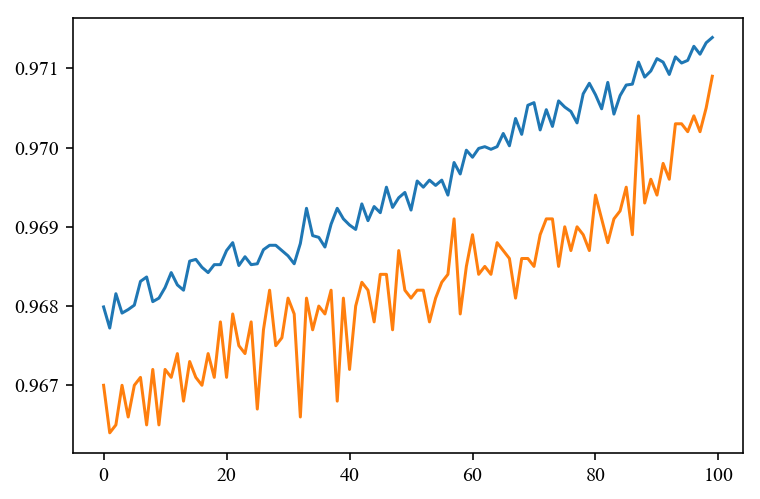

In [203]:
history = test_nn.fit(X, y, validation_split=0.1, epochs=100, batch_size=1024)

plt.plot(history.history['acc'], label = 'training acc')
plt.plot(history.history['val_acc'], label = 'validation acc')

In [172]:
f1_score(y[:,1], test_nn.predict(X)[:, 1] >= 0.5)

0.99635051132945651

In [161]:
(test_nn.predict(X)[:, 1] >= 0.5).sum()

91588